In [1]:
import numpy as np
import os
import pandas as pd
import re
from plotfx import *
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter

%matplotlib inline

In [3]:
sims = ['beta006_multiNPI_0vax_locom', 'beta006_multiNPI_20vax_locom', 'beta006_multiNPI_40vax_locom']
partitions = np.arange(5)
sim_names = [sim + '_' + str(part) + '.csv' for sim in sims for part in partitions]
outfile = 'multiNPI_vax_locom'

In [4]:
sim_names

['beta006_multiNPI_0vax_locom_0.csv',
 'beta006_multiNPI_0vax_locom_1.csv',
 'beta006_multiNPI_0vax_locom_2.csv',
 'beta006_multiNPI_0vax_locom_3.csv',
 'beta006_multiNPI_0vax_locom_4.csv',
 'beta006_multiNPI_20vax_locom_0.csv',
 'beta006_multiNPI_20vax_locom_1.csv',
 'beta006_multiNPI_20vax_locom_2.csv',
 'beta006_multiNPI_20vax_locom_3.csv',
 'beta006_multiNPI_20vax_locom_4.csv',
 'beta006_multiNPI_40vax_locom_0.csv',
 'beta006_multiNPI_40vax_locom_1.csv',
 'beta006_multiNPI_40vax_locom_2.csv',
 'beta006_multiNPI_40vax_locom_3.csv',
 'beta006_multiNPI_40vax_locom_4.csv']

In [5]:
df = pd.DataFrame()
for file in sim_names:
    tmpdf = pd.read_csv(file, header = 0, dtype = {'rep': int, 'p_vax': float, 'test_freq': int})
    part = int(file[-5])
    tmpdf['partition'] = np.repeat(part, repeats = tmpdf.shape[0])
    df = df.append(tmpdf, ignore_index = True)

In [6]:
# Linspace adds trailing decimal places in some cases
df['p_vax'] = df['p_vax'].round(decimals = 1)

In [7]:
df.shape

(181500, 8)

In [8]:
df.head()

,rep,test_freq,p_sd,p_fm,p_vax,cum_uniq_inf,ext_inf_ct,partition
0,1,0,0.0,0.0,0.0,397,35,0
1,2,0,0.0,0.0,0.0,408,31,0
2,3,0,0.0,0.0,0.0,282,24,0
3,4,0,0.0,0.0,0.0,377,47,0
4,5,0,0.0,0.0,0.0,350,29,0


In [9]:
# Renumber reps to remove duplicates
df['rep'] = df['rep'] + df['partition']*20
df.tail()

,rep,test_freq,p_sd,p_fm,p_vax,cum_uniq_inf,ext_inf_ct,partition
181495,96,28,1.0,1.0,0.4,26,25,4
181496,97,28,1.0,1.0,0.4,29,27,4
181497,98,28,1.0,1.0,0.4,38,35,4
181498,99,28,1.0,1.0,0.4,28,27,4
181499,100,28,1.0,1.0,0.4,32,31,4


### Plot Heatmaps by Immunization

In [10]:
aggdf = df.groupby(['test_freq','p_vax','p_sd','p_fm'])['cum_uniq_inf'].describe()
aggdf

count    mean        std    min     25%    50%  \
test_freq p_vax p_sd p_fm                                                   
0         0.0   0.0  0.0   100.0  364.30  49.978884  160.0  350.00  374.0   
                     0.1   100.0  288.58  59.213734   52.0  259.75  299.5   
                     0.2   100.0  226.27  56.647030   60.0  200.25  236.5   
                     0.3   100.0  173.03  54.725847   22.0  142.75  175.5   
                     0.4   100.0  119.21  39.133363   31.0   90.75  122.5   
...                          ...     ...        ...    ...     ...    ...   
28        0.4   1.0  0.6   100.0   27.12   6.453063   13.0   22.75   27.0   
                     0.7   100.0   26.26   6.611316   10.0   21.75   27.0   
                     0.8   100.0   26.09   6.444942   11.0   21.00   26.0   
                     0.9   100.0   25.73   6.353008   13.0   21.00   25.0   
                     1.0   100.0   24.38   6.409872   10.0   20.00   24.0   

                              75%    max  
test_freq p_vax p_sd p_fm                 
0         0.0   0.0  0.0   399.50  443.0  
                     0.1   325.50  385.0  
                     0.2   268.00  326.0  
                     0.3   211.25  320.0  
                     0.4   147.00  212.0  
...                           ...    ...  
28        0.4   1.0  0.6    32.00   48.0  
                     0.7    30.00   40.0  
                     0.8    31.00   47.0  
                     0.9    30.25   44.0  
                     1.0    28.00   40.0  

[1815 rows x 8 columns]

In [11]:
annotate = ["0%\nImmune", "20%\nImmune", "40%\nImmune", "60%\nImmune", "80%\nImmune"]
title = 'Every {freq} Days'
titles = [title.format(freq = f) for f in [3,7,14,28]] + ['Symptomatic Only']
titles

['Every 3 Days',
 'Every 7 Days',
 'Every 14 Days',
 'Every 28 Days',
 'Symptomatic Only']

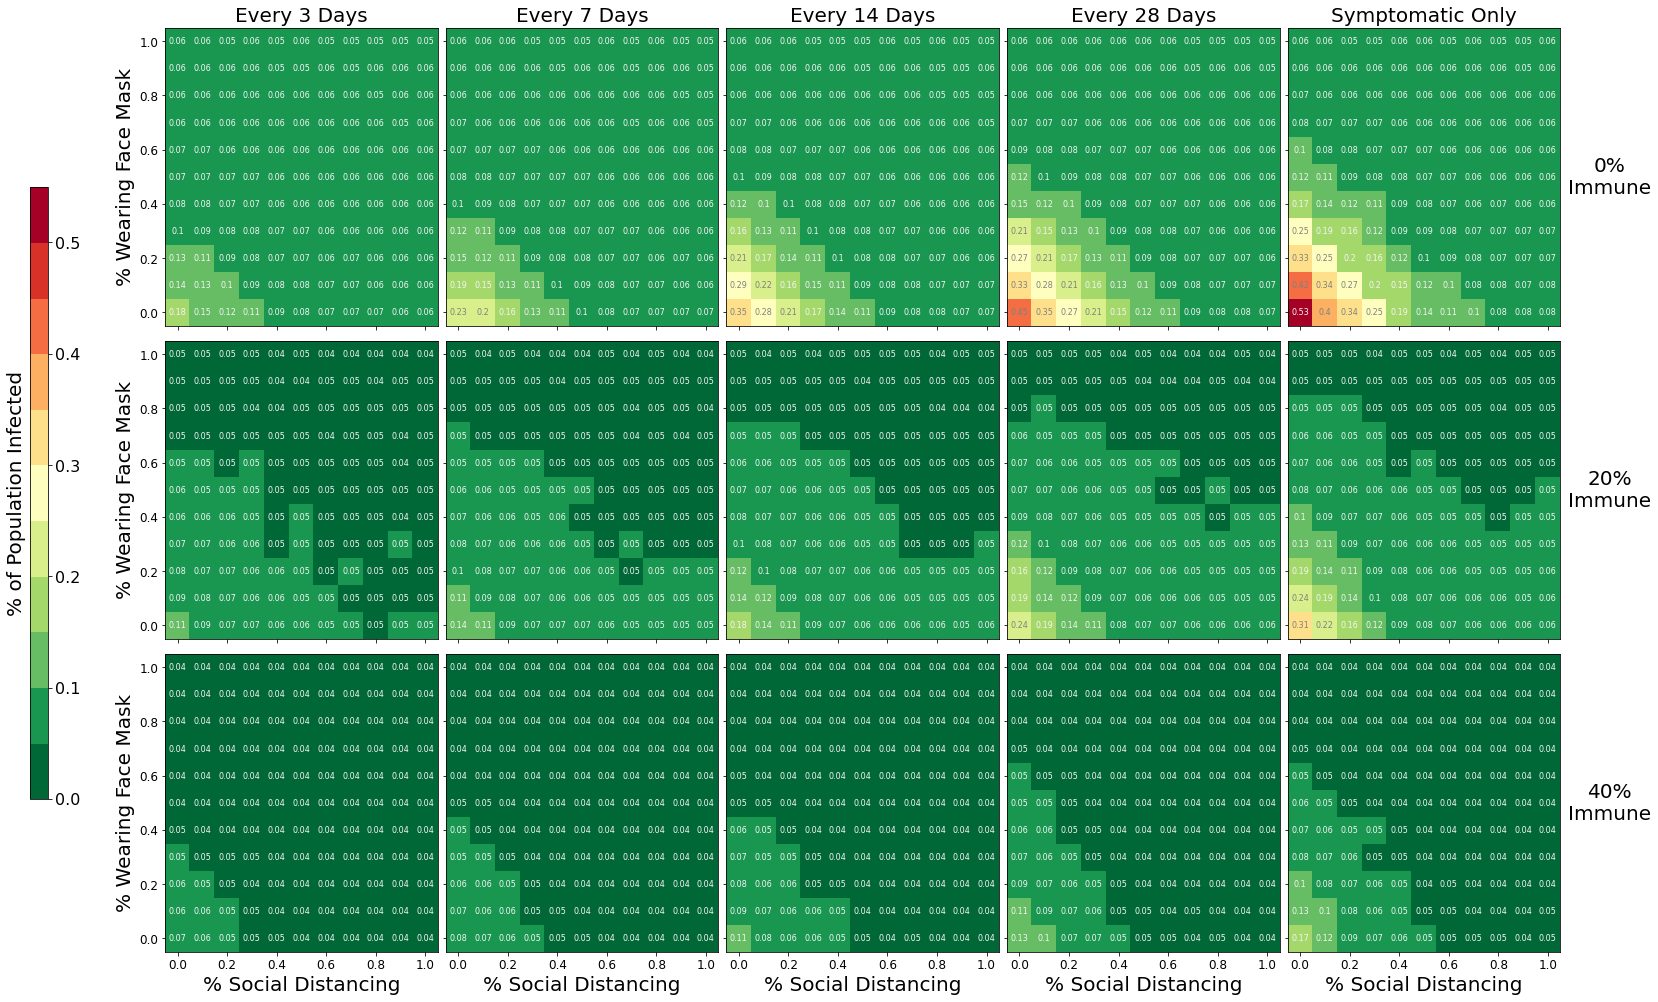

In [13]:
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'

f, axs = plt.subplots(3, 5, figsize = (25, 17), sharex = True, sharey = True)
#f.suptitle('Testing Frequency', fontsize = 20, y = 0.93)
f.subplots_adjust(wspace=0.03, hspace=0.05)

# Loop through rows
for (i, p_vax) in enumerate(df.p_vax.unique()):
    
    # Loop through testing values (columns)
    for (j, tf) in enumerate(df.test_freq.unique()):
        
        if tf==0:
            j = 4
        else:
            j = j-1
        
        # Format data
        pltdf = df.loc[(df.test_freq == tf) & (df.p_vax == p_vax)]
        xvals = pltdf.p_sd.unique()
        yvals = pltdf.p_fm.unique()
        pltx = [min(xvals)-0.05] + ((xvals[1:]+xvals[:-1])/2).tolist() + [max(xvals) + 0.05]
        plty = [min(yvals)-0.05] + ((yvals[1:]+yvals[:-1])/2).tolist() + [max(yvals) + 0.05]
        # Column index corresponds to x-coord, row corresponds to y-coord
        vals = np.array(pltdf.groupby(['p_sd','p_fm'])['cum_uniq_inf'].mean()).reshape((11,11)).T/692

        # Make plot
        bounds = np.linspace(0, 0.55, 12)
        norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
        im = axs[i,j].pcolormesh(pltx, plty, vals, norm = norm, cmap='RdYlGn_r')
        if i==0:
            axs[i,j].set_title(titles[j], fontsize = 20)
        if j==0:
            axs[i,j].set_ylabel('% Wearing Face Mask', fontsize = 20)
        if (i+1)==df.p_vax.nunique():
            axs[i,j].set_xlabel('% Social Distancing', fontsize = 20)
            
        # Adjust ticks and labels
        axs[i,j].tick_params(axis = 'x', labelsize = 12)
        axs[i,j].tick_params(axis = 'y', labelsize = 12)

        # Annotate if last column
        if (j+1)==df.test_freq.nunique():
            axs[i,j].text(1.25, 0.5, annotate[i], fontsize = 20, ha='center', va='center')

        # Add text annotations
        for (k, x) in enumerate(xvals):
            for (l, y) in enumerate(yvals):
                if (vals[l,k]>=0.2) & (vals[l,k]<=0.45):
                    text = axs[i,j].text(x, y, np.around(vals[l,k],2), ha="center", va="center", color = "gray", fontsize = 8)
                else:
                    text = axs[i,j].text(x, y, np.around(vals[l,k],2), ha="center", va="center", color = "whitesmoke", fontsize = 8)


# Add colorbar
cbar_ax = f.add_axes([0.05, 0.25, 0.01, 0.5])
f.colorbar(im, ax=axs.ravel().tolist(), cax = cbar_ax, label = '% of Population Infected')
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.yaxis.set_label_position('left')
cbar_ax.yaxis.label.set_size(20)
cbar_ax.tick_params(labelsize=16)
plt.savefig('Heatmap_locom_vax_trans.eps', bbox_inches='tight', transparent=True);